## TensorFlow

##### Advertencia: este notebook es una recopilacion/guia del trabajo realizado en el modelo final, se muestra el proceso realizado paso a paso, pero por motivos de rendimiento el numero de epocas se ha reducido a 5. en caso de uso elevar el numero de replicas a 100 como se usa en el modelo original.

In [2]:
#carga de librerias 
import cv2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics


import datetime, os
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix



#### Configuración dataset:
Para este modelo se ha usado el data set de Kaggle: 'Face expression recognition dataset'


[Dataset Kaggle](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset)


In [ ]:
# Definimos las rutas del dataset 
train_data_dir = './data/images/train'
val_data_dir = './data/images/validation'

# Definimos algunos parámetros importantes
width_shape = 48 #tamaño de las imagenes
height_shape = 48 #tamaño de las imagenes  
num_classes = 7 # Número de emociones 
epochs = 5 # El numero de epocas 
batch_size = 32 
class_names = ['angry','disgust','fear','happy','neutral','sad','surprise'] # El nombre de las clases en este caso emociones.

# Configuramos el dataset de entrenamiento y validación
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

#Configuración del Generador de Entrenamiento
train_generator = train_datagen.flow_from_directory(  
    train_data_dir, # Carpeta de imágenes de entrenamiento
    target_size=(width_shape, height_shape), # Redimensiona imágenes a 48x48
    batch_size=batch_size, # Procesa 32 imágenes a la vez
    color_mode='grayscale', # Convierte imágenes a escala de grises
    class_mode='categorical',shuffle=True) # Etiquetas en formato "one-hot encoding"

#Configuración del Generador de Validación
val_generator = val_datagen.flow_from_directory(  
    val_data_dir, # Carpeta de imágenes de validación
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Modelo CNN:
Definimos la arquitectura del modelo de red neuronal convolucional.

##### Extracción de Características:
- Se agregan varias capas convolucionales (`Conv2D`) con diferentes tamaños de filtro (3x3, 5x5).
- Se usa `BatchNormalization()` para estabilizar la distribución de activaciones.
- Se aplica la función de activación `ReLU` para introducir no linealidad.
- Se reduce la dimensionalidad con `MaxPool2D(pool_size=(2,2))`.
- Se usa `Dropout(0.2)` para prevenir sobreajuste.

##### Clasificación:
- Se aplana la salida de la última capa convolucional con `Flatten()`.
- Se agregan capas densas (`Dense`) para la clasificación.
- Se utiliza `softmax` en la última capa para obtener probabilidades de cada clase.

##### Compilación y Entrenamiento:
- Se usa la función de pérdida `categorical_crossentropy` (adecuada para clasificación multiclase).
- Se optimiza con `Adam` con una tasa de aprendizaje de `1e-4`.
- Se monitorea la precisión (`accuracy`) durante el entrenamiento.


In [7]:
#Codigo

model = Sequential()

## Extracción de Características
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (width_shape,height_shape,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

## Clasificación
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

# Revisamos el modelo CNN
model.summary()

# Compilamos y estamos listos para el entrenamiento
opt = Adam(learning_rate=1e-4, decay=1e-4 / epochs)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,706,759 (6.51 MB)

 Trainable params: 1,704,007 (6.50 MB)

 Non-trainable params: 2,752 (10.75 KB)

### Entrenamiento

In [9]:
#Entrenamos el modelo y vemos su resultado. 
model.fit(  
    train_generator, # Datos de entrenamiento generados en lotes
    epochs=epochs,  # Número total de épocas de entrenamiento 
    validation_data=val_generator, # Datos de validación para evaluar el modelo
    steps_per_epoch=train_generator.n//batch_size, # Número de lotes por época
    validation_steps=val_generator.n//batch_size, # Número de lotes en validación
    callbacks=[tensorboard_callback]) # Lista de callbacks (en este caso, TensorBoard) 

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.2067 - loss: 2.1054 - val_accuracy: 0.2705 - val_loss: 1.7854
Epoch 2/5
  1/900 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.3750 - loss: 1.5409

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3750 - loss: 1.5409 - val_accuracy: 0.2703 - val_loss: 1.7841
Epoch 3/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.2582 - loss: 1.8572 - val_accuracy: 0.3328 - val_loss: 1.6736
Epoch 4/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2500 - loss: 1.9356 - val_accuracy: 0.3338 - val_loss: 1.6731
Epoch 5/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.3296 - loss: 1.7092 - val_accuracy: 0.3945 - val_loss: 1.5669


### Salvamos el modelo 

In [10]:
#salvar el modelo como h5 
model.save('modelFECM.h5')

In [11]:
#salvar el modelo como keras
model.save("modelFECM.h52.keras")

### Pruebas y validacion 


1️ **Carga la imagen desde la ruta**  
   - Se define la ruta de la imagen a analizar.  

2️ **Convierte la imagen a escala de grises y la redimensiona a 48x48**  
   - Se usa `cv2.imread()` para leer la imagen.  
   - Se convierte a escala de grises con `cv2.cvtColor()`.  
   - Se redimensiona con `cv2.resize()`.  

3️ **Convierte la imagen en un array adecuado para el modelo**  
   - Se usa `img_to_array()` para transformar la imagen en un array NumPy.  
   - Se expande la dimensión con `np.expand_dims()` para formar un batch.  

4️ **Agrega la imagen a una lista (`faces`)**  
   - Se almacena la imagen preprocesada en una lista para pasársela al modelo.  

5️ **Usa un modelo para hacer una predicción**  
   - Se llama `model.predict(faces)` para obtener la probabilidad de cada categoría.  

6️ **Obtiene la categoría predicha e imprime el resultado**  
   - Se usa `np.argmax(preds)` para obtener el índice de la categoría con mayor probabilidad.  
   - Se imprime el nombre de la clase correspondiente en `class_names`.  

7️ **Muestra la imagen original con Matplotlib**  
   - Se convierte el formato de color de BGR a RGB para que Matplotlib la visualice correctamente.  
   - Se usa `plt.imshow()` para mostrar la imagen.  
   - Se ocultan los ejes con `plt.axis('off')`.  
   - Se llama `plt.show()` para renderizar la imagen.  

**Este proceso es típico en modelos de reconocimiento facial o detección de emociones basados en deep learning.**


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
sad


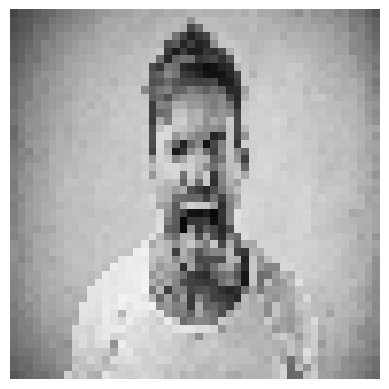

In [13]:
faces = []

# Cargamos una imagen del directorio
imaget_path = "./imagenes/enfado.jpg"

# Redimensionamos la imagen y convertimos a gray
face = cv2.cvtColor(cv2.imread(imaget_path), cv2.COLOR_BGR2GRAY)
face = cv2.resize(face, (48, 48))
face2 = img_to_array(face)
face2 = np.expand_dims(face2,axis=0)

faces.append(face2)

# El modelo estima la predicción
preds = model.predict(faces)

print(class_names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(face),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Matrix de confusion y metricas 

Este código se encarga de evaluar un modelo de clasificación de imágenes.    
Primero, crea un generador de datos de imágenes para cargar las imágenes de validación desde un directorio especificado   
(`val_data_dir`), con un tamaño de imagen definido por `target_size`, y en formato de escala de grises. Luego, realiza   
las predicciones usando el modelo entrenado (`model.predict()`), y las convierte en etiquetas de clase mediante `np.argmax()`.  
  
A continuación, se calcula la matriz de confusión (`confusion_matrix()`) entre las predicciones y las etiquetas reales.   
Esta matriz se visualiza con la función `plot_confusion_matrix()`. Finalmente, se imprime el informe de clasificación,   
que incluye métricas como precisión, recall y F1-score, con cuatro decimales, utilizando `metrics.classification_report()`.  


Found 7066 images belonging to 7 classes.
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           0     0.3333    0.0031    0.0062       960
           1     0.0000    0.0000    0.0000       111
           2     0.2458    0.0580    0.0938      1018
           3     0.4976    0.7890    0.6103      1825
           4     0.2845    0.6168    0.3894      1216
           5     0.2749    0.1089    0.1560      1139
           6     0.4952    0.5194    0.5070       797

    accuracy                         0.3948      7066
   macro avg     0.3045    0.2993    0.2518      7066
weighted avg     0.3584    0.3948    0.3213      7066



c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

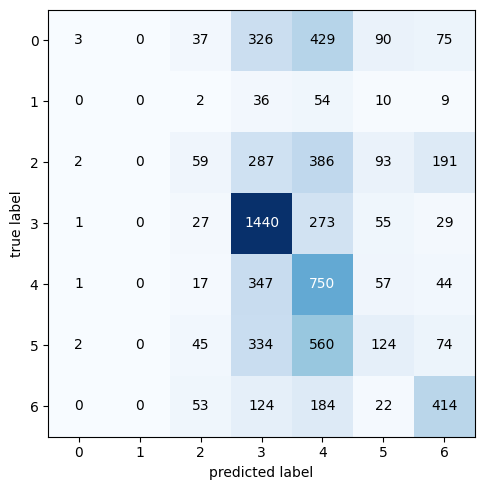

In [ ]:
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(  
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=False)

predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = val_generator.classes

matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))